This notebook contains an example calculation of the lightcurve of a Gaussian source as it moves across a caustic with and without random deflections due to DM substructure. The parameters of the caustic are chosen such that an analytic calculation matches precisely the numerical results (with no DM substructure).

In [11]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams.update({"text.usetex": True,"text.latex.preamble": r"\usepackage{bm}"})

from lens_map import *
import gaussian_source as src
import random_deflection


# A Lensing Test

No random deflections: smooth caustic model

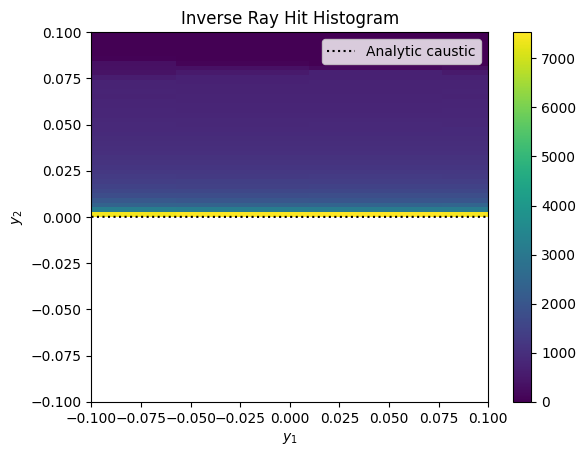

In [10]:
# Parameters that determine the lens equation near the caustic - see Schneider, Ehlers and Falco Ch. 6
phi_11, phi_22 = 0.8, 0.0 # This makes the caustic a horizontal line in the source plane

# These are chosen such that the caustic is well approximated by a parabola, i.e. so that we can compare with analytics
phi_111, phi_112, phi_122, phi_222 = 0.06/5., 0.05/5., 0.03/5., 0.05/5.

# This parameter controls the magnification
g = 2 / (phi_11 ** 2 * phi_222)

caustic_params = {'phi_11':phi_11, 'phi_22':phi_22, 'phi_111':phi_111, 'phi_112':phi_112, 'phi_122':phi_122, 'phi_222':phi_222}
caustic_params['random_deflection'] = None

# Size and discretization of the lens and source planes
num_pixel_lns, num_pixel_src = 2001, 2001 # Number of pixels in both planes
half_size_lns, half_size_src = 4.0, 0.1 # Half size of the lens and source planes
pixel_size_lns, pixel_size_src = 2.0 * half_size_lns / (num_pixel_lns - 1), 2.0 * half_size_src / (num_pixel_src - 1) # horizontal and vertical physical pixel size

domain_size = 2*half_size_lns

# indices for the lens plane pixels.
# Note: arrays are indexed as by [j1,j2], so j2 (j1) indexes horizontal (vertical) directions
j1, j2 = np.mgrid[0:num_pixel_lns, 0:num_pixel_lns] 

# this maps pixels indices to physical coord as [0,0] -> (-L,L), [0,N-1]-> (L,L) etc
x1, x2 = pixel_to_pos(j2, -half_size_lns, pixel_size_lns), pixel_to_pos(j1,half_size_lns, -pixel_size_lns)

y1, y2 = lens_mapping(x1, x2, caustic_params)

# Convert deflected coordinates to source plane pixels
i1, i2 = pos_to_pixel(y2, half_size_src, -pixel_size_src), pos_to_pixel(y1, -half_size_src, pixel_size_src)

# Diagnostic histogram of ray hits
hit_mask = (i1 >= 0) & (i1 < num_pixel_src) & (i2 >= 0) & (i2 < num_pixel_src)
hit_pixel_coords = np.transpose((i1[hit_mask].flatten(),i2[hit_mask].flatten()))
hit_source_plane_coords = np.transpose((y1[hit_mask].flatten(),y2[hit_mask].flatten()))
hit_source_plane_coords = np.transpose((y1.flatten(),y2.flatten()))
plt.hist2d(hit_source_plane_coords[:,0],hit_source_plane_coords[:,1],bins=100)
plt.colorbar()
y = np.linspace(-half_size_src, half_size_src, num_pixel_src)
plt.plot(y, (phi_112*phi_222 - phi_122**2)*np.power(y,2)/(2.*phi_11**2 * phi_222),\
             c='k',ls=':',label="Analytic caustic")
plt.xlim([-half_size_src,half_size_src])
plt.ylim([-half_size_src,half_size_src])
plt.xlabel(r"$y_1$")
plt.ylabel(r"$y_2$")
plt.title("Inverse Ray Hit Histogram")

plt.legend()
plt.show()


In [3]:
jac = lens_mapping_jacobian(x1,x2,caustic_params)
print(jac.shape)
print(jac[0,0,:,:])

(2001, 2001, 2, 2)
[[ 0.792 -0.016]
 [-0.016  0.016]]


/tmp/ipykernel_79565/3438894418.py:4: RuntimeWarning: divide by zero encountered in divide
  jac_plt = plt.imshow(1/np.abs(jac_det),vmin=1,vmax=500)


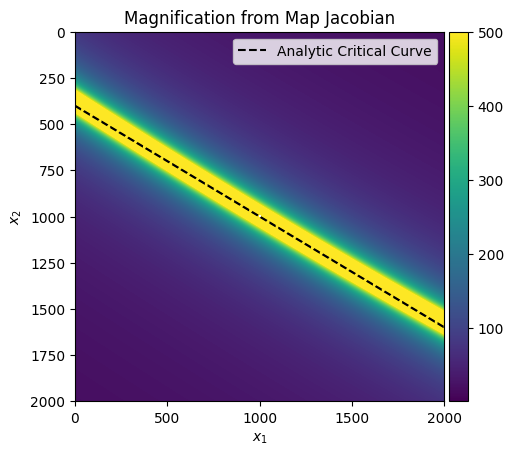

In [8]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
#jac_det=-(x1**2*(phi_112**2)) + x1*phi_11*phi_122 - x1*x2*phi_112*phi_122 - x2**2*phi_122**2 + x2*phi_11*phi_222 + x2**2*phi_112*phi_222
jac_det = np.linalg.det(jac)
jac_plt = plt.imshow(1/np.abs(jac_det),vmin=1,vmax=500)
plt.plot(pos_to_pixel(x1[0], -half_size_lns, pixel_size_lns), pos_to_pixel(- phi_122 * x1[0] / phi_222,half_size_lns,-pixel_size_lns),c='k',ls='--',label='Analytic Critical Curve')
plt.title("Magnification from Map Jacobian")

plt.xlabel(r"$x_1$")
plt.ylabel(r"$x_2$")
plt.legend()
p = plt.gca()
divider1 = make_axes_locatable(p)
cax = divider1.append_axes("right", size="5%", pad=0.05)
plt.gca().figure.colorbar(jac_plt, cax=cax)




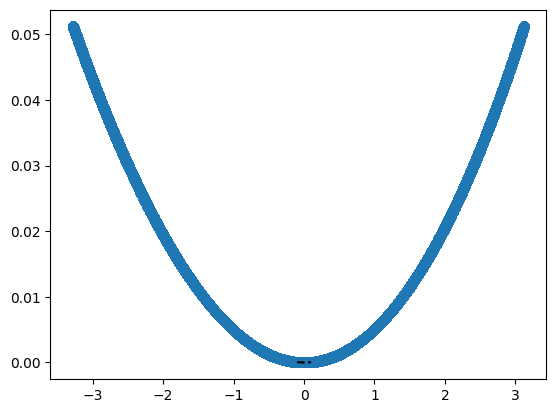

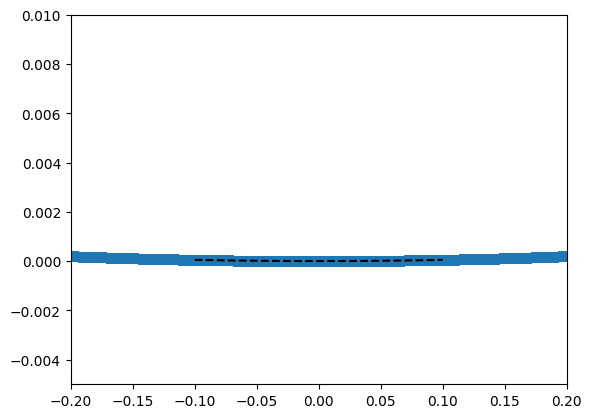

In [5]:
# the scatter plot shows the paramatric representation of the caustic without making many approximations
# to derive the parabola however, one needs to drop some terms
aaa = np.transpose(((x1*phi_11 + x1**2*(phi_122**3 - 2*phi_112*phi_122*phi_222)/(2.*phi_222**2)).flatten(),\
             (x1**2*(-phi_122**2 + phi_112*phi_222)/(2.*phi_222)).flatten()))

plt.scatter(aaa[:,0],aaa[:,1])
plt.plot(y, (phi_112*phi_222 - phi_122**2)*np.power(y,2)/(2.*phi_11**2 * phi_222),\
             c='k',ls='--')
plt.show()

plt.scatter(aaa[:,0],aaa[:,1])
plt.plot(y, (phi_112*phi_222 - phi_122**2)*np.power(y,2)/(2.*phi_11**2 * phi_222),\
             c='k',ls='--')
plt.xlim([-0.2,0.2])
plt.ylim([-0.005,.01])
plt.show()

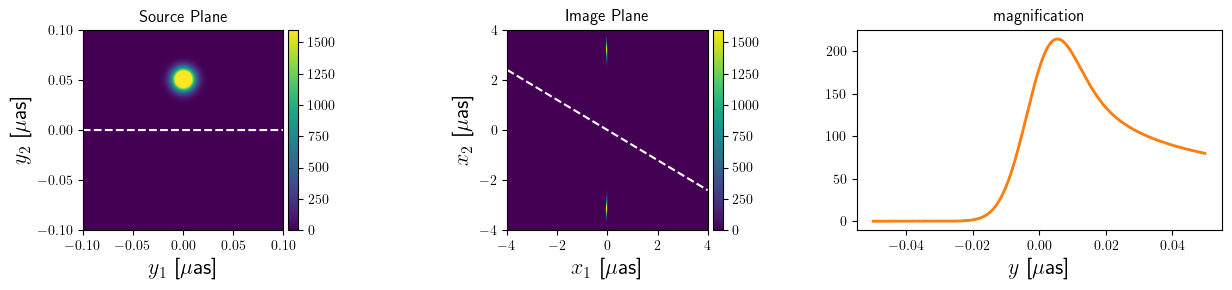

In [13]:
xpos, rad = 0.0, 0.01
ypos = 0.01

ypos_values = np.linspace(-0.05, 0.05, 400)
magnifications = np.zeros_like(ypos_values)

from matplotlib import animation
from mpl_toolkits.axes_grid1 import make_axes_locatable
    
fig, (ax1, ax2, ax3) = plt.subplots(1, 3,figsize=(13, 3))
ax1.set_title('Source Plane')
ax2.set_title('Image Plane')
ax3.set_title('magnification')

y = np.linspace(-half_size_src, half_size_src, num_pixel_src)

# Analytic caustic
#ax1.plot(pos_to_pixel(y, -half_size_src, pixel_size_src), \
#         pos_to_pixel((phi_112*phi_222 - phi_122**2)*np.power(y,2)/(2.*phi_11**2 * phi_222),half_size_src,-pixel_size_src),\
#             c='w',ls='--')
ax1.plot(y,(phi_112*phi_222 - phi_122**2)*np.power(y,2)/(2.*phi_11**2 * phi_222),c='w',ls='--')
# Analytic critical line
#ax2.plot(pos_to_pixel(x1[0], -half_size_lns, pixel_size_lns), \
#         pos_to_pixel(- phi_122 * x1[0] / phi_222,half_size_lns,-pixel_size_lns),c='w',ls='--')
ax2.plot(x1[0],- phi_122 * x1[0] / phi_222,c='w',ls='--')

# Analytic magnification for a gaussian source
analytic = [np.sqrt(g / rad) * src.analytic_gaussian_source_magnification(-ypos / rad) for ypos in ypos_values]
ax3.plot(ypos_values, analytic, '--', label="Analytic solution for Gaussian Source")
ax3.set_xlabel(r'$y$ [$\mu$as]',fontsize=16)

mag_plot, = ax3.plot([ypos_values[0]],[0.],'-',lw=2)

j1_src, j2_src = np.mgrid[0:num_pixel_src,0:num_pixel_src]
y1_full_src, y2_full_src = pixel_to_pos(j2_src, -half_size_src, pixel_size_src), pixel_to_pos(j1_src, half_size_src, -pixel_size_src)
src_plane = ax1.imshow(src.gaussian_source(y1_full_src, y2_full_src, rad, c=[xpos,ypos_values[0]]),vmin=0, vmax=1600,\
                       extent=(-half_size_src,half_size_src,-half_size_src,half_size_src))
img_plane = ax2.imshow(src.gaussian_source(y1,y2, rad, c=[xpos,ypos_values[0]]),vmin=0, vmax=1600,\
                      extent=(-half_size_lns,half_size_lns,-half_size_lns,half_size_lns))
ax1.set_xlabel(r'$y_1$ [$\mu$as]',fontsize=16)
ax1.set_ylabel(r'$y_2$ [$\mu$as]',fontsize=16)
ax2.set_xlabel(r'$x_1$ [$\mu$as]',fontsize=16)
ax2.set_ylabel(r'$x_2$ [$\mu$as]',fontsize=16)
divider1 = make_axes_locatable(ax1)
cax1 = divider1.append_axes("right", size="5%", pad=0.05)
divider2 = make_axes_locatable(ax2)
cax2 = divider2.append_axes("right", size="5%", pad=0.05)

cbar = fig.colorbar(src_plane, cax=cax1)
cbar = fig.colorbar(img_plane, cax=cax2)
fig.tight_layout()

def animate(i):
    ypos = ypos_values[i]

    lensed_source = src.gaussian_source(y1,y2,rad, c=[xpos,ypos])

    src_plane.set_data(src.gaussian_source(y1_full_src,y2_full_src,rad, c=[xpos,ypos]))
    img_plane.set_data(lensed_source)

    # Calculate magnifications
    intensity_norm = 1. # assume it is normalized #np.sum(a_gaussian) * ys * ys
    mag = np.sum(lensed_source) * (pixel_size_lns ** 2) / intensity_norm

    magnifications[i] = mag
    mag_plot.set_data(ypos_values[:i], magnifications[:i])
    return(src_plane,img_plane,mag_plot)


anim = animation.FuncAnimation(fig=fig, func=animate, frames=len(ypos_values), interval=20)
anim.save('basic_animation.mp4', fps=30, extra_args=['-vcodec', 'libx264'])

plt.show()




# Physically-Motivated Power Spectrum
Smooth caustic + random deflections due to convergence drawn from a power spectrum corresponding to (truncated) NFW minihalos of a fixed mass.

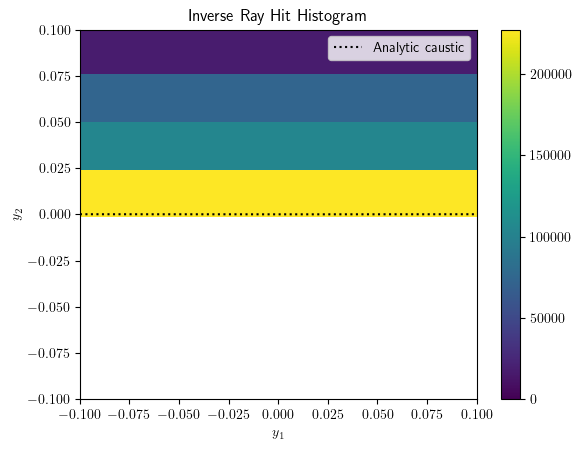

In [14]:

arcmin = np.pi/(180*60.)
arcsec = np.pi/(180*60.*60.)
microarcsec = 1e-6*arcsec

# Parameters that determine the lens equation near the caustic - see Schneider, Ehlers and Falco Ch. 6
phi_11, phi_22 = 0.8, 0.0 # This makes the caustic a horizontal line in the source plane

# These are chosen such that the caustic is well approximated by a parabola, i.e. so that we can compare with analytics
phi_111, phi_112, phi_122, phi_222 = 0.06/5., 0.05/5., 0.03/5., 0.05/5.

# This parameter controls the magnification
g = 2 / (phi_11 ** 2 * phi_222)

caustic_params = {'phi_11':phi_11, 'phi_22':phi_22, 'phi_111':phi_111, 'phi_112':phi_112, 'phi_122':phi_122, 'phi_222':phi_222}



# Size and discretization of the lens and source planes
num_pixel_lns, num_pixel_src = 2001, 2001 # Number of pixels in both planes
half_size_lns, half_size_src = 4.0, 0.1 # Half size of the lens and source planes
pixel_size_lns, pixel_size_src = 2.0 * half_size_lns / (num_pixel_lns - 1), 2.0 * half_size_src / (num_pixel_src - 1) # horizontal and vertical physical pixel size

domain_size = 2*half_size_lns

# Random noise - make sure parameters supplied to power spectrum are in radians
deflection_params = {'pixel_size_in_rad':pixel_size_lns*microarcsec, 'num_pixel':num_pixel_lns, 'area_in_rad_sq': (2.*half_size_lns*microarcsec)**2} 
#Parameters needed for power spectrum here
ps_params = {'M':2e-6, 'c': 1200, 'DL': 1.35, 'DS':1.79, 'DLS':0.95, 'dm_mass_fraction':1}
deflection_params['ps_params'] = ps_params
# the output is in rad, so convert it to microarcsec
caustic_params['random_deflection'] = random_deflection.generate_random_field(deflection_params)/microarcsec

# indices for the lens plane pixels.
# Note: arrays are indexed as by [j1,j2], so j2 (j1) indexes horizontal (vertical) directions
j1, j2 = np.mgrid[0:num_pixel_lns, 0:num_pixel_lns] 

# this maps pixels indices to physical coord as [0,0] -> (-L,L), [0,N-1]-> (L,L) etc
x1, x2 = pixel_to_pos(j2, -half_size_lns, pixel_size_lns), pixel_to_pos(j1, half_size_lns, -pixel_size_lns)

y1, y2 = lens_mapping(x1, x2, caustic_params)

# Convert deflected coordinates to source plane pixels
i1, i2 = pos_to_pixel(y2, half_size_src, -pixel_size_src), pos_to_pixel(y1, -half_size_src, pixel_size_src)

# Diagnostic histogram of ray hits
hit_mask = (i1 >= 0) & (i1 < num_pixel_src) & (i2 >= 0) & (i2 < num_pixel_src)
hit_pixel_coords = np.transpose((i1[hit_mask].flatten(),i2[hit_mask].flatten()))
hit_source_plane_coords = np.transpose((y1[hit_mask].flatten(),y2[hit_mask].flatten()))
hit_source_plane_coords = np.transpose((y1.flatten(),y2.flatten()))
plt.hist2d(hit_source_plane_coords[:,0],hit_source_plane_coords[:,1])
plt.colorbar()
y = np.linspace(-half_size_src, half_size_src, num_pixel_src)
plt.plot(y, (phi_112*phi_222 - phi_122**2)*np.power(y,2)/(2.*phi_11**2 * phi_222),\
             c='k',ls=':',label="Analytic caustic")
plt.xlim([-half_size_src,half_size_src])
plt.ylim([-half_size_src,half_size_src])
plt.xlabel(r"$y_1$")
plt.ylabel(r"$y_2$")
plt.title("Inverse Ray Hit Histogram")

plt.legend()
plt.show()

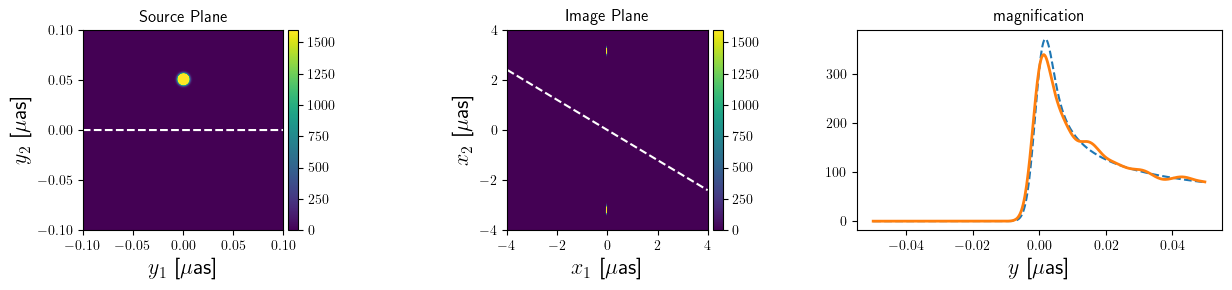

In [16]:
xpos, rad = 0.0, 0.01/3
ypos_values = np.linspace(-0.05, 0.05, 400)
magnifications = np.zeros_like(ypos_values)
magnifications_with_noise = np.zeros_like(ypos_values)

from matplotlib import animation
from mpl_toolkits.axes_grid1 import make_axes_locatable
    
fig, (ax1, ax2, ax3) = plt.subplots(1, 3,figsize=(13, 3))
ax1.set_title('Source Plane')
ax2.set_title('Image Plane')
ax3.set_title('magnification')

y = np.linspace(-half_size_src, half_size_src, num_pixel_src)

# Analytic caustic
#ax1.plot(pos_to_pixel(y, -half_size_src, pixel_size_src), \
#         pos_to_pixel((phi_112*phi_222 - phi_122**2)*np.power(y,2)/(2.*phi_11**2 * phi_222),half_size_src,-pixel_size_src),\
#             c='w',ls='--')
ax1.plot(y,(phi_112*phi_222 - phi_122**2)*np.power(y,2)/(2.*phi_11**2 * phi_222),c='w',ls='--')
# Analytic critical line
#ax2.plot(pos_to_pixel(x1[0], -half_size_lns, pixel_size_lns), \
#         pos_to_pixel(- phi_122 * x1[0] / phi_222,half_size_lns,-pixel_size_lns),c='w',ls='--')
ax2.plot(x1[0],- phi_122 * x1[0] / phi_222,c='w',ls='--')

# Analytic magnification for a gaussian source
analytic = [np.sqrt(g / rad) * src.analytic_gaussian_source_magnification(-ypos / rad) for ypos in ypos_values]
ax3.plot(ypos_values, analytic, '--', label="Analytic solution for Gaussian Source")
ax3.set_xlabel(r'$y$ [$\mu$as]',fontsize=16)

mag_plot, = ax3.plot([ypos_values[0]],[0.],'-',lw=2)
j1_src, j2_src = np.mgrid[0:num_pixel_src,0:num_pixel_src]
y1_full_src, y2_full_src = pixel_to_pos(j2_src, -half_size_src, pixel_size_src), pixel_to_pos(j1_src, half_size_src, -pixel_size_src)
src_plane = ax1.imshow(src.gaussian_source(y1_full_src, y2_full_src, rad, c=[xpos,ypos_values[0]]),vmin=0, vmax=1600,\
                       extent=(-half_size_src,half_size_src,-half_size_src,half_size_src))
img_plane = ax2.imshow(src.gaussian_source(y1,y2, rad, c=[xpos,ypos_values[0]]),vmin=0, vmax=1600,\
                       extent=(-half_size_lns,half_size_lns,-half_size_lns,half_size_lns))

ax1.set_xlabel(r'$y_1$ [$\mu$as]',fontsize=16)
ax1.set_ylabel(r'$y_2$ [$\mu$as]',fontsize=16)
ax2.set_xlabel(r'$x_1$ [$\mu$as]',fontsize=16)
ax2.set_ylabel(r'$x_2$ [$\mu$as]',fontsize=16)

divider1 = make_axes_locatable(ax1)
cax1 = divider1.append_axes("right", size="5%", pad=0.05)
divider2 = make_axes_locatable(ax2)
cax2 = divider2.append_axes("right", size="5%", pad=0.05)

cbar = fig.colorbar(src_plane, cax=cax1)
cbar = fig.colorbar(img_plane, cax=cax2)
fig.tight_layout()

def animate(i):
    ypos = ypos_values[i]

    lensed_source = src.gaussian_source(y1,y2,rad, c=[xpos,ypos])
    
    src_plane.set_data(src.gaussian_source(y1_full_src,y2_full_src,rad, c=[xpos,ypos]))
    img_plane.set_data(lensed_source)

    # Calculate magnifications
    intensity_norm = 1. # assume it is normalized #np.sum(a_gaussian) * ys * ys
    mag = np.sum(lensed_source) * (pixel_size_lns ** 2) / intensity_norm

        
    magnifications[i] = mag
    mag_plot.set_data(ypos_values[:i], magnifications[:i])

    return(src_plane,img_plane,mag_plot)




anim = animation.FuncAnimation(fig=fig, func=animate, frames=len(ypos_values), interval=20)
anim.save('basic_animation_with_clumps.mp4', fps=30, extra_args=['-vcodec', 'libx264'])

plt.show()

